# Classifica els diferents vols

Anem a practicar i a familiaritzar-nos amb algoritmes de clustering.

**Exercici 1**

Classifica els diferents vols utilitzant l'algorisme de K-means.

**Exercici 2**

Classifica els diferents vols utilitzant l'algorisme de clustering jeràrquic.

**Exercici 3**

Calcula el rendiment del clustering mitjançant un paràmetre com pot ser silhouette.

In [1]:
import pandas as pd
pd.set_option("display.max_columns", None)

import numpy as np
from scipy import stats 

from sklearn.cluster import KMeans

from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy as sch

from sklearn.preprocessing import StandardScaler

from sklearn.metrics import silhouette_score

import matplotlib.pyplot as plt

# Data

[Airlines Delay: Airline on-time statistics and delay causes](https://www.kaggle.com/giovamata/airlinedelaycauses) 

- Year: 1987-2008
- Month: 1-12
- DayofMonth: 1-31
- DayOfWeek: 1 (Monday) - 7 (Sunday)
- DepTime: departure time (local, hhmm)
- CRSDepTime: scheduled departure time (local, hhmm)
- ArrTime: arrival time (local, hhmm)
- CRSArrTime: scheduled arrival time (local, hhmm)
- UniqueCarrier: unique carrier code
- FlightNum: flight number
- TailNum: plane tail number 
- ActualElapsedTime: flygth time in minutes (Total)
- CRSElapsedTime: scheduled	flygth time in minutes (Total)
- AirTime: time on air in minutes
- ArrDelay:	arrival delay in minutes
- DepDelay: departure delay in minutes
- Origin: origin IATA airport code
- Dest:	destination IATA airport code
- Distance: distance in miles
- TaxiIn: taxi in time, in minutes (movement on ground)
- TaxiOut: taxi out time, in minutes (movement on ground)
- Cancelled: was the flight cancelled?
- CancellationCode:	[reason for cancellation](https://aspmhelp.faa.gov/index/Types_of_Delay.html) (A = carrier, B = weather, C = NAS, D = security)
- Diverted:	1 = yes, 0 = no ("Desviado")
- CarrierDelay:	delayed time due to Carrier in minutes
- WeatherDelay:	delayed time due to Weather in minutes
- NASDelay: delayed time due to NAS in minutes
- SecurityDelay: delayed time due to security in minuts
- LateAircraftDelay: delayed time due to late aircraft in minutes

In [2]:
# Read csv
df_raw = pd.read_csv("./archive/DelayedFlights.csv", index_col = [0])

/Users/luis/opt/anaconda3/lib/python3.8/site-packages/numpy/lib/arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [3]:
## Columns and Data types
df_raw.info(show_counts = True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1936758 entries, 0 to 7009727
Data columns (total 29 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   Year               1936758 non-null  int64  
 1   Month              1936758 non-null  int64  
 2   DayofMonth         1936758 non-null  int64  
 3   DayOfWeek          1936758 non-null  int64  
 4   DepTime            1936758 non-null  float64
 5   CRSDepTime         1936758 non-null  int64  
 6   ArrTime            1929648 non-null  float64
 7   CRSArrTime         1936758 non-null  int64  
 8   UniqueCarrier      1936758 non-null  object 
 9   FlightNum          1936758 non-null  int64  
 10  TailNum            1936753 non-null  object 
 11  ActualElapsedTime  1928371 non-null  float64
 12  CRSElapsedTime     1936560 non-null  float64
 13  AirTime            1928371 non-null  float64
 14  ArrDelay           1928371 non-null  float64
 15  DepDelay           1936758 non-n

In [4]:
## Drop Duplicates
df_raw.drop_duplicates(inplace = True)

In [5]:
## Columns with low percentage of nulls (less than 2% in total)
subset = ["ArrTime", "TailNum", "ActualElapsedTime", "CRSElapsedTime", 
          "AirTime", "ArrDelay", "TaxiIn", "TaxiOut"]
## Drop rows with low percentage of nulls
df_raw = df_raw.dropna(subset=subset)

In [6]:
## Transform DepTime and ArrTime to a more consistent notation (hh:mm)
df_raw["DepTime"] = df_raw["DepTime"].astype(int).apply(lambda x: str(x).zfill(4)).apply(lambda x: x[0:2] + ":" + x[2:]) 
df_raw["CRSDepTime"] = df_raw["CRSDepTime"].astype(int).apply(lambda x: str(x).zfill(4)).apply(lambda x: x[0:2] + ":" + x[2:]) 
df_raw["ArrTime"] = df_raw["ArrTime"].astype(int).apply(lambda x: str(x).zfill(4)).apply(lambda x: x[0:2] + ":" + x[2:]) 
df_raw["CRSArrTime"] = df_raw["CRSArrTime"].astype(int).apply(lambda x: str(x).zfill(4)).apply(lambda x: x[0:2] + ":" + x[2:]) 

In [7]:
## Change dtypes
df_raw["FlightNum"] = df_raw["FlightNum"].astype(str)
df_raw["Cancelled"] = df_raw["Cancelled"].astype(str)
df_raw["Diverted"] = df_raw["Diverted"].astype(str)

In [8]:
## Drop Year
df_raw.drop(columns = "Year", inplace = True)

In [9]:
## Drop Cancelled, CancellationCode and Diverted
df_raw.drop(columns = ["Cancelled", "CancellationCode", "Diverted"], inplace = True)

In [10]:
## Categorical column with delay > 15 min (1 = Yes, 0 = No)
df_raw["DelayCat"] = df_raw["ArrDelay"].apply(lambda x: 1 if x > 15 else 0)

## Mean Velocity columns in miles/min
df_raw = df_raw[df_raw["AirTime"] != 0]
df_raw["Velocity"] = df_raw["Distance"] / df_raw["AirTime"] 

## Origin-Destination Columns
df_raw["Fligth"] = df_raw["Origin"] + "-" + df_raw["Dest"]

In [11]:
## Save Final Dataframe
df_raw.to_csv("df_clean.csv")

# Exercisi 1

In [12]:
# Read csv
df_clean = pd.read_csv("df_clean.csv", index_col = [0])

/Users/luis/opt/anaconda3/lib/python3.8/site-packages/numpy/lib/arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [13]:
# Sample
df_clean.sample(10)

,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,TailNum,ActualElapsedTime,CRSElapsedTime,AirTime,ArrDelay,DepDelay,Origin,Dest,Distance,TaxiIn,TaxiOut,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay,DelayCat,Velocity,Fligth
1528059,3,12,3,17:09,16:45,22:20,21:59,F9,720,N201FR,191.0,194.0,177.0,21.0,24.0,DEN,DCA,1476,5.0,9.0,15.0,0.0,6.0,0.0,0.0,1,8.338983,DEN-DCA
2305316,4,8,2,07:47,07:35,10:33,10:30,AA,1970,N5CNAA,166.0,175.0,138.0,3.0,12.0,MIA,EWR,1086,11.0,17.0,NaN,NaN,NaN,NaN,NaN,0,7.869565,MIA-EWR
2459169,5,24,6,19:06,18:55,19:43,19:40,WN,1017,N637SW,37.0,45.0,28.0,3.0,11.0,HOU,AUS,148,4.0,5.0,NaN,NaN,NaN,NaN,NaN,0,5.285714,HOU-AUS
2735250,5,16,5,11:49,07:55,13:13,09:09,F9,332,N809FR,84.0,74.0,55.0,244.0,234.0,ABQ,DEN,349,13.0,16.0,234.0,0.0,10.0,0.0,0.0,1,6.345455,ABQ-DEN
923175,2,27,3,10:50,10:09,12:05,11:25,EV,4616,N916EV,135.0,136.0,109.0,40.0,41.0,ATL,ATW,765,4.0,22.0,40.0,0.0,0.0,0.0,0.0,1,7.018349,ATL-ATW
2265315,4,25,5,16:04,13:45,18:46,16:25,AA,321,N425AA,162.0,160.0,141.0,141.0,139.0,ORD,AUS,978,6.0,15.0,21.0,0.0,2.0,0.0,118.0,1,6.936170,ORD-AUS
556175,1,19,6,16:18,15:50,19:03,19:04,B6,454,N523JB,165.0,194.0,150.0,-1.0,28.0,FLL,BOS,1237,5.0,10.0,NaN,NaN,NaN,NaN,NaN,0,8.246667,FLL-BOS
6617259,12,23,2,12:30,11:15,13:40,11:51,OO,2623,N468CA,70.0,36.0,24.0,109.0,75.0,MKE,MSN,74,3.0,43.0,75.0,0.0,34.0,0.0,0.0,1,3.083333,MKE-MSN
2191612,4,24,4,18:04,17:40,19:16,18:50,MQ,4178,N672AE,132.0,130.0,107.0,26.0,24.0,RIC,ORD,642,11.0,14.0,0.0,0.0,2.0,0.0,24.0,1,6.000000,RIC-ORD
2618567,5,25,7,21:17,21:09,22:37,22:46,UA,423,N520UA,140.0,157.0,125.0,-9.0,8.0,DEN,SFO,967,5.0,10.0,NaN,NaN,NaN,NaN,NaN,0,7.736000,DEN-SFO


In [14]:
# Variables
x = df_clean[["DepDelay", "Distance"]]

In [15]:
# Remove outliers from x
z_scores = np.abs(stats.zscore(x))
filtered_entries = (z_scores < 3).all(axis=1)
x = x[filtered_entries]

In [16]:
# Inicializar Scaler
Scaler = StandardScaler()
# Escalar Variables
x.loc[:,:] = Scaler.fit_transform(x.values)

In [17]:
# Kmedias
kmeans = KMeans(init="random", n_clusters=3, n_init=10, max_iter=300, random_state=42).fit(x)

In [18]:
# Clústers
categories = kmeans.labels_
colormap = np.array(['r', 'g', 'b'])

Text(0, 0.5, 'Distance')

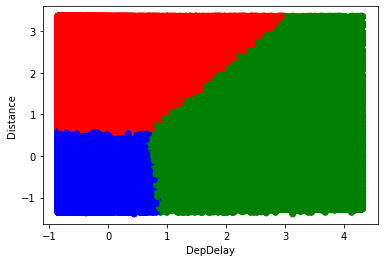

In [19]:
# Plot
plt.scatter(x.DepDelay, x.Distance, c=colormap[categories])
plt.xlabel("DepDelay")
plt.ylabel("Distance")

Dividiendo los vuelos en 3 clústers utilizando las variablas DepDelay y Distance obtenemos la siguiente clasificación.

# Exercisi 2

Debido a las dimensiones del dataset utilizamos una muestra representativa para este cálculo.

In [20]:
x_reducido = x.sample(10000)

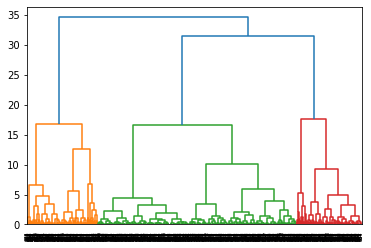

In [21]:
# Dendograma
dendrogram = sch.dendrogram(sch.linkage(x_reducido.sample(1000), method='ward'))

Segun el criterio de selección de clústers a partir del dendograma, el número óptimo de clústers es 3. 

In [22]:
# Kmedias jerarquico
model = AgglomerativeClustering(n_clusters=3, affinity='euclidean', linkage='ward').fit(x_reducido)

In [23]:
# Clústers
categories = model.labels_
colormap = np.array(['r', 'g', 'b'])

Text(0, 0.5, 'Distance')

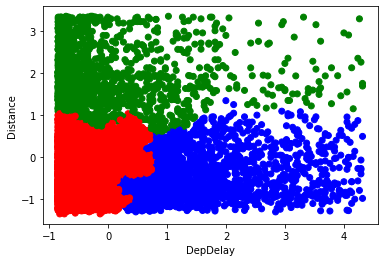

In [24]:
# Plot
plt.scatter(x_reducido.DepDelay, x_reducido.Distance, c=colormap[categories])
plt.xlabel("DepDelay")
plt.ylabel("Distance")

# Exercisi 3

In [25]:
# Elbow method
kmeans_kwargs = {"init": "random", "n_init": 10, "max_iter": 300, "random_state": 42}

# A list holds the SSE values for each k
sse = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs).fit(x)
    sse.append(kmeans.inertia_) # Distance to center metric (accuracy)

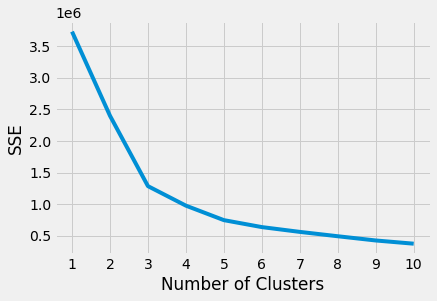

In [26]:
# Plot
plt.style.use("fivethirtyeight")
plt.plot(range(1, 11), sse)
plt.xticks(range(1, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()

Según el criterio del codo el número óptimo de clústers podría ser 3 o 5.

In [27]:
# silhouette coefficients
kmeans_kwargs = {"init": "random", "n_init": 10, "max_iter": 300, "random_state": 42}

# A list holds the silhouette coefficients = [] values for each k
silhouette_coefficients = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs).fit(x_reducido)
    score = silhouette_score(x_reducido, kmeans.labels_)
    silhouette_coefficients.append(score)

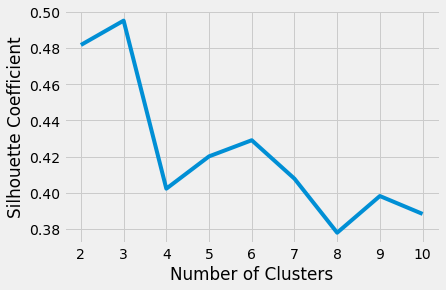

In [28]:
# Plot
plt.style.use("fivethirtyeight")
plt.plot(range(2, 11), silhouette_coefficients)
plt.xticks(range(2, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Coefficient")
plt.show()

Debido al coste computacional, utilizamos una muestra representativa para realizar esta evaluación. Los coeficientes de silueta son una medida de cohesión y separación entre los distintos clústers. Dentro del rango -1/1, cuanto más alto sea el valor más diferenciados estan los clústers entre sí. En nuestro caso, de nuevo el 3 es el número óptimo de clústers.